# 2021/10/21
The jupypter notebook is used to test the pipleine for the ENN + SMOTE + random forest pipeline intergration from sklearn for single parameter


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import pandas as pd
import numpy as np
import sys, os

# Load the data

In [4]:
input_path='/pod/2/li-lab/Ziwei/Nanopore/daily/test/'
#df=pd.read_csv(os.path.join(input_path, 'total.Megalodon.per_read.prob.bed.gz'),compression='gzip', sep='\t')
df=pd.read_csv(os.path.join(input_path, 'total.test.bed'), sep='\t')
print("Data is loading!")

#Splitting the data into independent and dependent variables
df_feature = df.loc[:,['5hmC_prob','5mC_prob','5C_prob']].values
df_class = df.loc[:,['label']].values
df_class = np.squeeze(df_class) #Convert the label into 1d-array

df

Data is loading!


,chr,start,read_id,strand,5hmC_prob,5mC_prob,5C_prob,label
0,KJ477685.1,204,3e547b1a-0a3e-4475-9b70-0cbd7c8c82aa,-,0.435397,0.085058,0.479545,2
1,KJ477685.1,261,3e547b1a-0a3e-4475-9b70-0cbd7c8c82aa,-,0.342189,0.500821,0.156990,2
2,KJ477685.1,261,fe8be0cc-f4c4-49f1-80db-c840a6c7dfe9,-,0.577034,0.057676,0.365290,2
3,KJ477685.1,266,3e547b1a-0a3e-4475-9b70-0cbd7c8c82aa,-,0.065316,0.861569,0.073115,2
4,KJ477685.1,266,fe8be0cc-f4c4-49f1-80db-c840a6c7dfe9,-,0.794235,0.028885,0.176880,2
...,...,...,...,...,...,...,...,...
2492,J02459.1,60,bb826a6c-c88b-45ac-9984-8b9d6bfb2f11,-,0.054875,0.013023,0.932103,0
2493,J02459.1,60,bb91267a-6661-4248-a084-554f231398c1,-,0.030720,0.004392,0.964888,0
2494,J02459.1,60,bb9cee29-89d0-4a68-a4b4-8fe5c000289f,-,0.032703,0.006934,0.960363,0
2495,J02459.1,60,bbee6b4a-acac-4db9-bbb8-2f379918b146,-,0.035734,0.003182,0.961085,0


In [5]:
df['label'].value_counts()

1    999
0    999
2    499
Name: label, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, GridSearchCV
#from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [6]:
#Load the feature
input_path='/pod/2/li-lab/Ziwei/Nanopore/daily/test'
#df=pd.read_csv(os.path.join(input_path, 'total.Megalodon.per_read.prob.bed.gz'),compression='gzip', sep='\t')
df=pd.read_csv(os.path.join(input_path, 'total.test.bed'), sep='\t')

#Splitting the data into independent and dependent variables
df_feature = df.loc[:,['5hmC_prob','5mC_prob','5C_prob']].values
df_class = df.loc[:,['label']].values
df_class = np.squeeze(df_class) #Convert the label into 1d-array

X = df_feature
y = df_class

In [7]:
n = np.bincount(y)[-1]
key=[0,1,2]
value = [(1*n, 1*n, n)]
for i in value:
    sampling_strategy = dict(zip(key, i)).copy()
sampling_strategy

{0: 499, 1: 499, 2: 499}

In [8]:
from collections import Counter
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler
sampler = RandomUnderSampler(random_state = 42, sampling_strategy=sampling_strategy)

X_res, y_res = sampler.fit_resample(X, y)
print(Counter(y_res))

Counter({0: 499, 1: 499, 2: 499})


In [9]:
y_res

array([0, 0, 0, ..., 2, 2, 2])

In [10]:
#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_res,
                                                    y_res,
                                                    test_size=0.2,
                                                    stratify=y_res,
                                                    random_state=42)
print("Before the pipeline:\n y_train:{},\n y_test: {}".format(Counter(y_train), Counter(y_test)))

Before the pipeline:
 y_train:Counter({2: 399, 1: 399, 0: 399}),
 y_test: Counter({0: 100, 1: 100, 2: 100})


## Hyperparemter tuning

In [11]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from datetime import datetime

#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# 5 * 2 * 4 * 3 * 3 = 360

# Define model
rf_model = RandomForestClassifier(random_state=42)

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

#Define parameter
#10x2x5x2x2x2=800
n_estimators =  [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(start = 5, stop = 25, num = 5)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 5] # minimum sample number to split a node
min_samples_leaf = [1, 2] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


#Create Stratified K-fold cross validation
#cv = RepeatedStratifiedKFold(n_splits=5 n_repeats=3, random_state=1)


##Grid search
#rf = GridSearchCV(estimator = rf_model, 
#                         param_grid = params, 
#                         scoring='f1_macro', 
#                         cv=cv, 
#                         verbose=3, 
#                         verbose=1, 
#                         return_train_score=True, 
#                         n_jobs=-1)


##RandomSearch
rf = RandomizedSearchCV(estimator = rf_model, 
                          param_distributions = params, 
                          scoring='f1_macro', 
                          cv=cv, 
                          verbose=1,   
                          n_iter=10,  ##find parameter number
                          return_train_score=True, 
                          n_jobs=-1)

rf_result = rf.fit(X_train, y_train)
y_true, y_pred = y_test, rf.predict(X_test)

cv_score = rf_result.best_score_
test_score = rf_result.score(X_test, y_test)

print ('Best Parameters: ',rf_result.best_params_, ' \n')
print('Best f1_score in cv:', cv_score, '\n')
print('Test score:', test_score)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters:  {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': True}  

Best f1_score in cv: 0.9124169880711455 

Test score: 0.906781379218354


In [12]:
y_pred

array([0, 1, 2, 2, 2, 1, 0, 0, 0, 2, 0, 2, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2,
       1, 0, 0, 1, 0, 0, 1, 2, 1, 0, 0, 1, 1, 2, 1, 0, 1, 2, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 2, 2, 2, 0, 1, 0, 0, 1, 2,
       0, 0, 2, 0, 2, 0, 1, 1, 2, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2,
       2, 0, 0, 1, 2, 2, 0, 2, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 0,
       2, 1, 1, 1, 2, 0, 1, 1, 2, 1, 0, 2, 0, 0, 1, 2, 1, 2, 0, 1, 2, 1,
       2, 2, 0, 0, 1, 2, 0, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 0,
       0, 1, 0, 1, 2, 2, 0, 0, 2, 1, 2, 0, 2, 1, 2, 1, 2, 0, 1, 1, 2, 1,
       2, 0, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 0, 2, 2, 2, 0,
       2, 0, 2, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 1, 0, 2, 0, 2, 2, 0, 0,
       1, 2, 2, 0, 1, 0, 0, 1, 2, 1, 1, 0, 1, 0, 2, 2, 2, 0, 2, 2, 2, 1,
       1, 1, 0, 1, 2, 2, 0, 2, 2, 0, 1, 0, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 1, 2, 2, 0, 1, 2, 2, 0, 0, 2, 0, 0,
       1, 2, 2, 0, 1, 2, 0, 1, 2, 2, 1, 2, 0, 0])

In [129]:
##Save best parameter
#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
import joblib
#joblib.dump(rf.best_estimator_, os.path.join(output_path,pkl_model))
    
 ##Save the cv result 
cv_table = pd.DataFrame(rf_result.cv_results_)
cv_table
#cv_table.to_csv(os.path.join(output_path, cv_result), sep='\t', index = True)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,...,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,mean_train_score,std_train_score
0,0.032974,0.004684,0.003303,0.000392,20,2,2,auto,10,True,...,0.948836,0.962493,0.957280,0.961413,0.965588,0.958310,0.955254,0.950018,0.957786,0.004893
1,0.085935,0.005765,0.006813,0.000389,70,5,1,auto,15,False,...,1.000000,1.000000,1.000000,0.998955,1.000000,0.998955,1.000000,1.000000,0.999582,0.000512
2,0.036440,0.000356,0.003423,0.000041,30,5,1,sqrt,20,False,...,1.000000,1.000000,1.000000,0.996867,1.000000,0.998955,1.000000,1.000000,0.999304,0.000908
3,0.111215,0.000344,0.008322,0.000040,100,2,1,sqrt,5,True,...,0.926997,0.943726,0.933437,0.935363,0.935420,0.927049,0.932295,0.934324,0.933634,0.005154
4,0.083321,0.001099,0.006680,0.000059,70,2,1,sqrt,10,False,...,0.993743,0.998957,0.987487,0.996868,0.998955,0.995827,0.992710,0.993740,0.994506,0.003966
5,0.024236,0.000337,0.002516,0.000040,20,2,2,sqrt,20,False,...,0.991663,0.990612,0.991660,0.993745,0.994777,0.992700,0.992700,0.990612,0.992557,0.001608
6,0.036180,0.000227,0.003260,0.000018,30,5,1,sqrt,10,True,...,0.965730,0.976058,0.968780,0.973941,0.976045,0.966634,0.963618,0.958333,0.966979,0.005927
7,0.096071,0.000906,0.007572,0.000073,80,5,1,sqrt,25,False,...,1.000000,1.000000,1.000000,0.998955,1.000000,0.998955,1.000000,0.998957,0.999513,0.000521
8,0.066979,0.000227,0.005513,0.000430,60,5,1,auto,5,True,...,0.931223,0.940551,0.932425,0.937477,0.932270,0.929205,0.930191,0.932152,0.933007,0.004866
9,0.109059,0.001432,0.008501,0.000094,90,2,1,sqrt,20,False,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [137]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def plot_cm(y_true, y_pred, filename, label = ['5C', '5mC', '5hmC'], figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with annotations.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    cm = confusion_matrix(y_true, y_pred)
    # Normalise
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
    
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmn = pd.DataFrame(cmn, index=label, columns=label)
    cmn.index.name = 'True label'
    cmn.columns.name = 'Predicted label'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cmn, annot=annot, fmt='', ax=ax, cmap="Blues")
#    plt.savefig(filename)

NameError: name 'class_report' is not defined

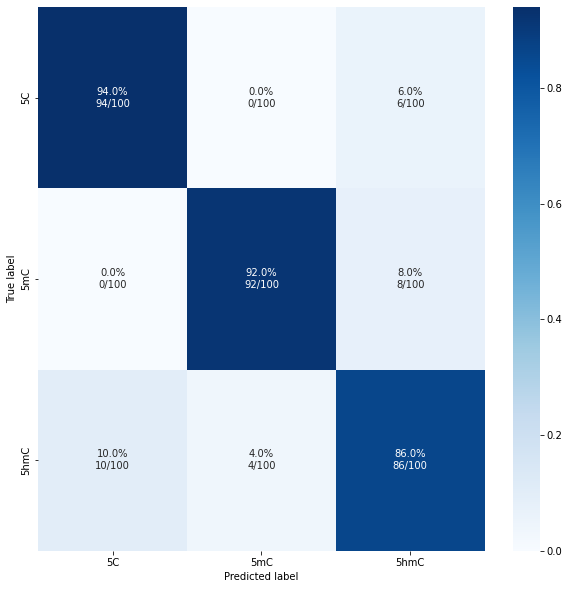

In [138]:
   
##Save the confusion matrix   
output_path='/pod/2/li-lab/Ziwei/Nanopore/daily/test/'
cm_png='test.png'
plot_cm(y_test, y_pred, os.path.join(output_path, cm_png))
    
## Save the classification report
target_class = ['5C', '5mC', '5hmC']
report = classification_report(y_test, y_pred, target_names=target_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report.to_csv(os.path.join(output_path, class_report), header = True, index= None, sep = ',', float_format='%.4f')
    
print("Saving is done!")
